# Wildfire detection

## Introduction
In this part we will try to solve the image segmentation task in aplication for wildfire detection using satelite image data.

### Dataset descriprion.
For this part we will use part of the dataset described at the paper "Active Fire Detection in Landsat-8 Imagery: A Large-Scale Dataset and a Deep-Learning Study" [Pereira et al. (2021)](https://arxiv.org/pdf/2101.03409.pdf).

You can download dataset from [Kaggle](https://www.kaggle.com/code/pe4eniks/jax-flax-optax-orbax-fire-segmentation-on-tpu/input).

In total using dataset contain 12854 unique satellite images and 22689 masks generated by [Kumar and Roy (2018)](https://doi.org/10.1080/17538947.2017.1391341), [Murphy et al. (2016)](https://doi.org/10.1016/j.rse.2016.02.027), and  [Schroeder et al. (2016)](https://doi.org/10.1016/j.rse.2015.08.032).

Images have the same name structure:
LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX

Where:


*   L = Landsat
*   X = Sensor (“C”=OLI/TIRS combined, “O”=OLI-only, “T”=TIRS-only, “E”=ETM+, “T”=“TM, “M”=MSS)
*   SS = Satellite (”07”=Landsat 7, “08”=Landsat 8)
*   LLL = Processing correction level (L1TP/L1GT/L1GS)
*   PPP = WRS path
*   RRR = WRS row
*   YYYYMMDD = Acquisition year, month, day
*   yyyymmdd - Processing year, month, day
*   CC = Collection number (01, 02, …)
*   TX = Collection category (“RT”=Real-Time, “T1”=Tier 1, “T2”=Tier 2)


## Data import
Import all libs and dataset for training and validation

Let's import all nessesary libs

In [ ]:
%%capture
!pip install rasterio
!pip install pydot
!apt-get install graphviz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2

from typing import Any, List, Type, Union, Optional, Dict
from IPython.display import Image
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model


Data copied tho the google drive disk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CSV-file contains spreadsheet with the paths for each image and mask.

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CV_data/fire-segmentation-db-europe-short.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CV_data/fire-segmentation-db-na2.csv')
df.head()

Unnamed: 0                                              image  \
0      230567  /content/drive/MyDrive/Colab Notebooks/CV_data...   
1      230568  /content/drive/MyDrive/Colab Notebooks/CV_data...   
2      230569  /content/drive/MyDrive/Colab Notebooks/CV_data...   
3      230570  /content/drive/MyDrive/Colab Notebooks/CV_data...   
4      230571  /content/drive/MyDrive/Colab Notebooks/CV_data...   

                                                mask           region  
0  /content/drive/MyDrive/Colab Notebooks/CV_data...  north-america-1  
1  /content/drive/MyDrive/Colab Notebooks/CV_data...  north-america-1  
2  /content/drive/MyDrive/Colab Notebooks/CV_data...  north-america-1  
3  /content/drive/MyDrive/Colab Notebooks/CV_data...  north-america-1  
4  /content/drive/MyDrive/Colab Notebooks/CV_data...  north-america-1

Function to read image.
If you would like change bands, when change "channels" parameters. In our case for wildfire detection we will use combination of the channels 7, 6, and 2.

In [ ]:
def read_img(path: str, channels: List[int] = [7, 6, 2]):
    img = rasterio.open(path).read(channels).transpose((1, 2, 0))
    img = np.float32(img) / 65535  # Normalize the pixel values
    return img

The same function for mask reading.

In [ ]:
def read_mask(path: str):
    mask = rasterio.open(path).read().transpose((1, 2, 0))
    mask = np.int32(mask)
    return mask

In [ ]:
iloc = 1154 # number of image in the dataset
img = read_img(df.iloc[iloc]['image'])  # Automatically reads the predefined channels (bands)
mask = read_mask(df.iloc[iloc]['mask'])


Visualize image builded from selected bands.

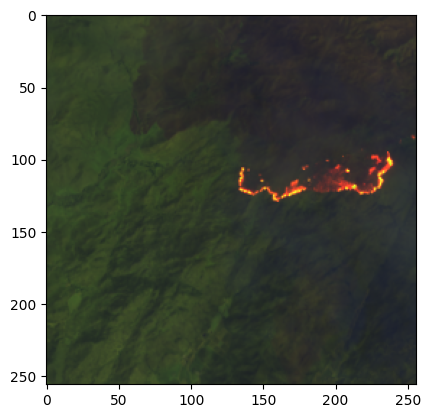

In [ ]:
_ = plt.imshow(img)

Vizualize mask sample

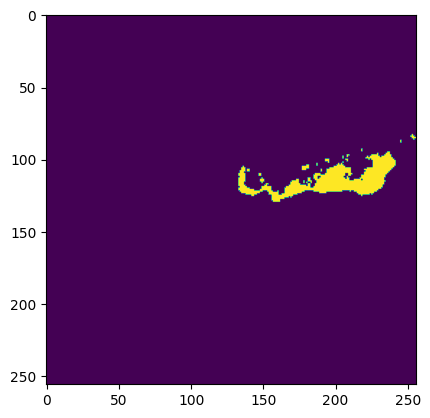

In [ ]:
# vizualize mask sample
_ = plt.imshow(mask)

## Model preparation & train
Build functions for model training

We will use a CNN architecture known as U-Net, which is widely used for image segmentation tasks due to it's efficiency and performance.

Let's split your dataset into training and validation sets. The 'df' contains two columns: 'image' for image paths and 'mask' for mask paths

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['image'], df['mask'], test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples.")


Training on 18151 samples, validating on 4538 samples.


According to the large size of the images and masks, it's efficient to use a data generator that loads images and masks on-the-fly during training.

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, augmentations=None, resize=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.resize = resize

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def load_and_preprocess_image(self, img_path, mask_path):
        img = read_img(img_path)
        mask = read_mask(mask_path)

        if self.resize:
            img = cv2.resize(img, self.resize)
            mask = cv2.resize(mask, self.resize)

        if self.augmentations:
            # Apply augmentations
            pass

        return img, np.expand_dims(mask, -1)

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        X = np.zeros((len(batch_x), *self.resize, 3), dtype=np.float32)
        Y = np.zeros((len(batch_y), *self.resize, 1), dtype=np.float32)

        with ThreadPoolExecutor(max_workers=8) as executor:
            future_to_image = {executor.submit(self.load_and_preprocess_image, img_path, mask_path): i for i, (img_path, mask_path) in enumerate(zip(batch_x, batch_y))}
            for future in as_completed(future_to_image):
                i = future_to_image[future]
                img, mask = future.result()
                X[i,] = img
                Y[i,] = mask

        return X, Y


Define the U-Net model architecture.

In [ ]:
def improved_unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.25)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.25)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.25)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.25)(c5)

    # Upsampling path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

Let's visualize model architecture

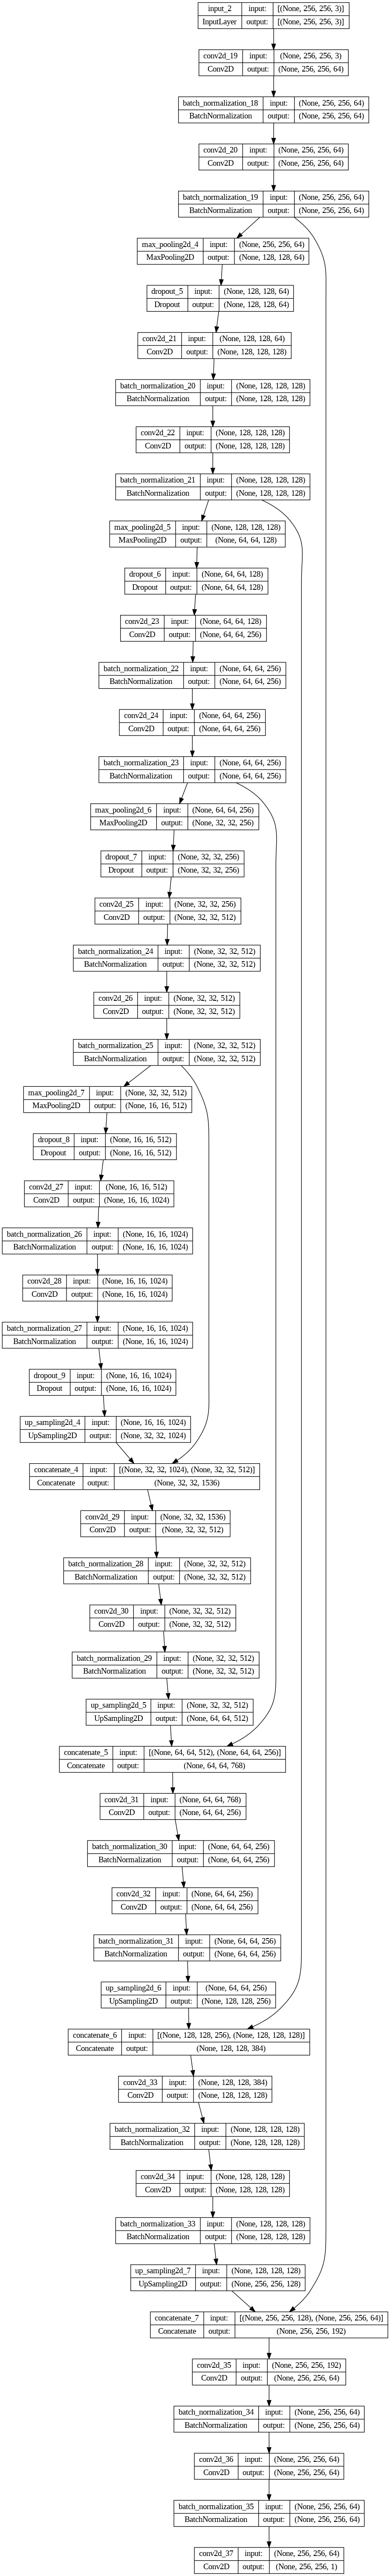

In [ ]:
model = improved_unet_model()

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Image('model_architecture.png')

Compile and train model. For 5 epoch it takes a time.

In [ ]:
model = improved_unet_model(input_size=(256, 256, 3))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

train_gen = DataGenerator(X_train.tolist(), y_train.tolist(), batch_size=16, resize=(256, 256))
val_gen = DataGenerator(X_val.tolist(), y_val.tolist(), batch_size=16, resize=(256, 256))

history = model.fit(train_gen, validation_data=val_gen, epochs=5)


Epoch 1/5
1135/1135 [==============================] - 8634s 8s/step - loss: 0.0589 - accuracy: 0.9942 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/5
1135/1135 [==============================] - 780s 687ms/step - loss: 6.4042e-04 - accuracy: 1.0000 - val_loss: 3.3669e-04 - val_accuracy: 1.0000
Epoch 3/5
1135/1135 [==============================] - 778s 686ms/step - loss: 2.5411e-04 - accuracy: 1.0000 - val_loss: 1.9788e-04 - val_accuracy: 1.0000
Epoch 4/5
1135/1135 [==============================] - 776s 684ms/step - loss: 1.7642e-04 - accuracy: 1.0000 - val_loss: 1.3062e-04 - val_accuracy: 1.0000
Epoch 5/5
1135/1135 [==============================] - 779s 686ms/step - loss: 1.2652e-04 - accuracy: 1.0000 - val_loss: 1.0795e-04 - val_accuracy: 1.0000


Save model

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/CV_data/models/my_model_WF_segment_v2_ep5.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/CV_data/models/my_model_WF_segment_v2_ep5_full')


## Load saved model

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CV_data/models/my_model_WF_segment_v2_ep5.h5')

In [ ]:
model

Evaluate the model

In [ ]:
# Evaluate the model
val_gen = DataGenerator(X_val.tolist(), y_val.tolist(), batch_size=16, resize=(256, 256))
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

284/284 [==============================] - 2957s 10s/step - loss: 1.0795e-04 - accuracy: 1.0000
Validation loss: 0.00010794571426231414, Validation accuracy: 0.9999683499336243


## Model quality and Visualisation

Let's visualize the inputs, the true masks, and the predicted masks

1/1 [==============================] - 0s 399ms/step


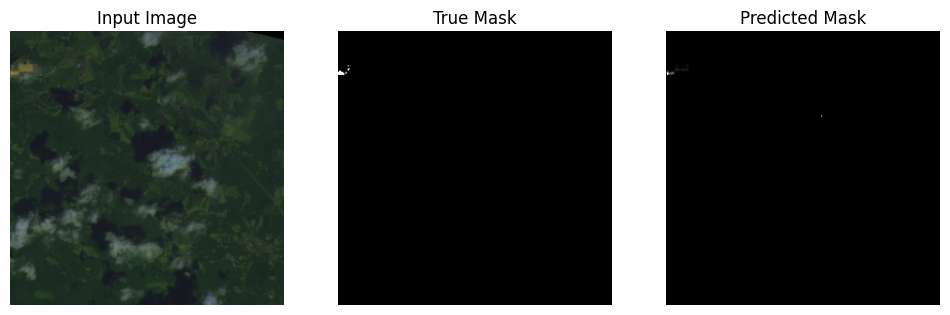

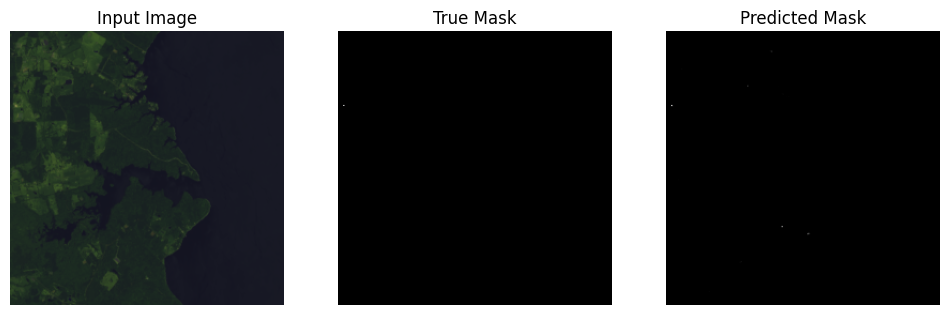

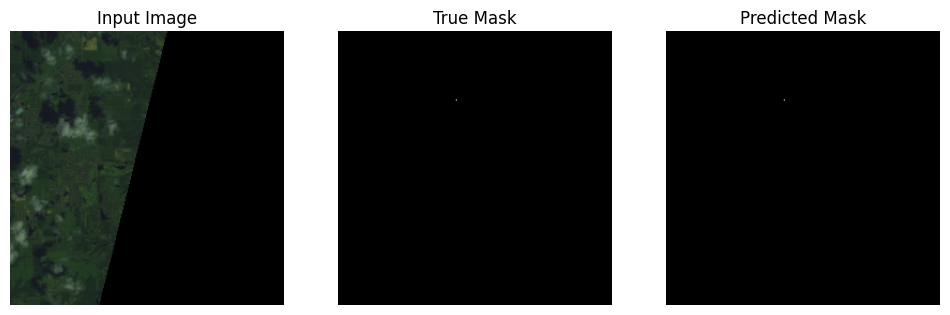

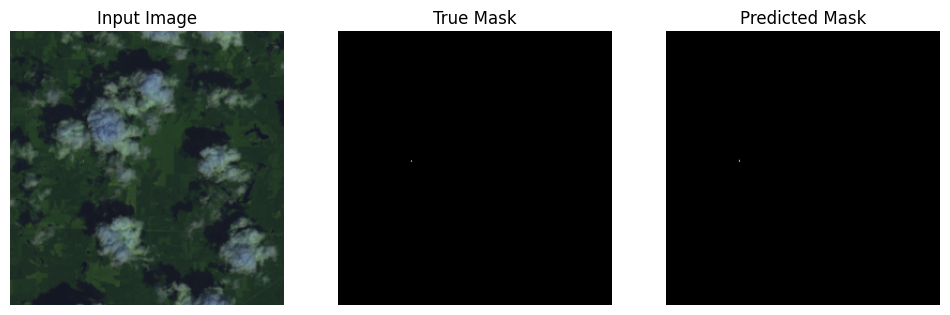

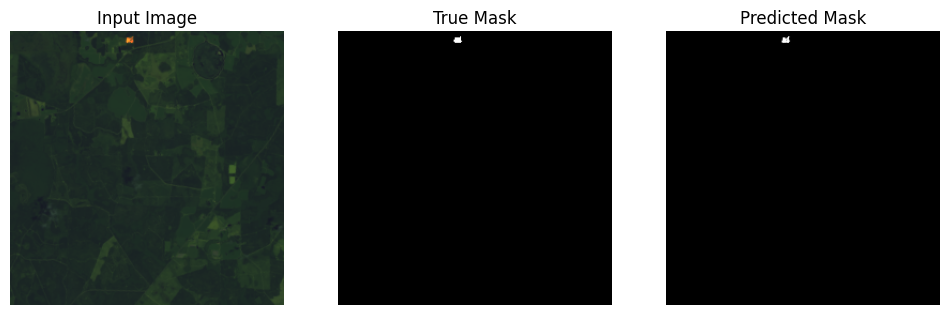

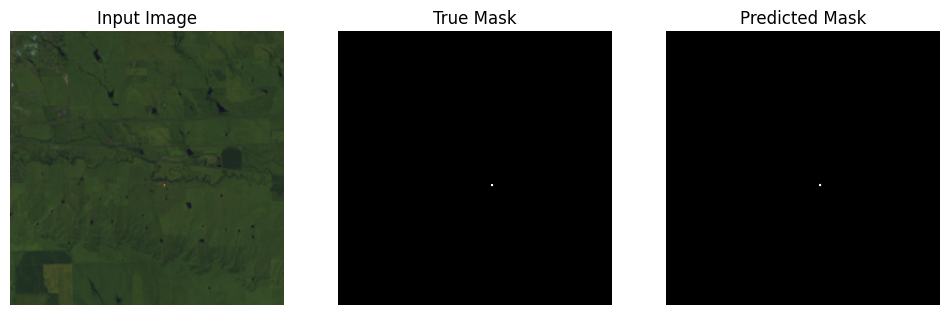

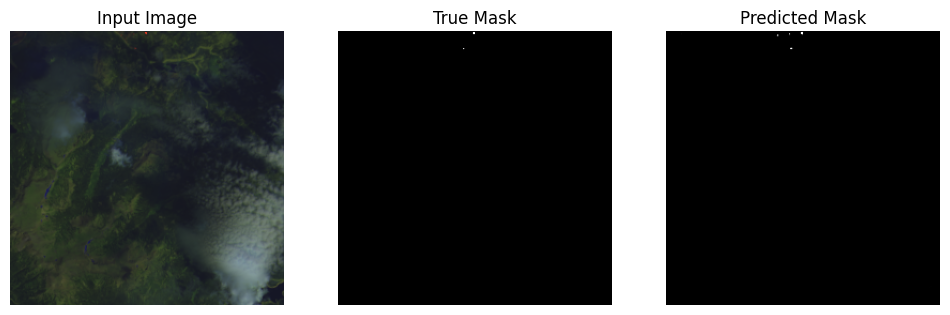

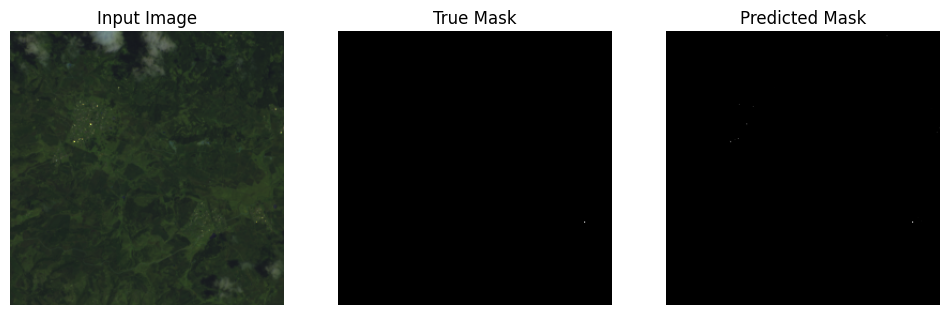

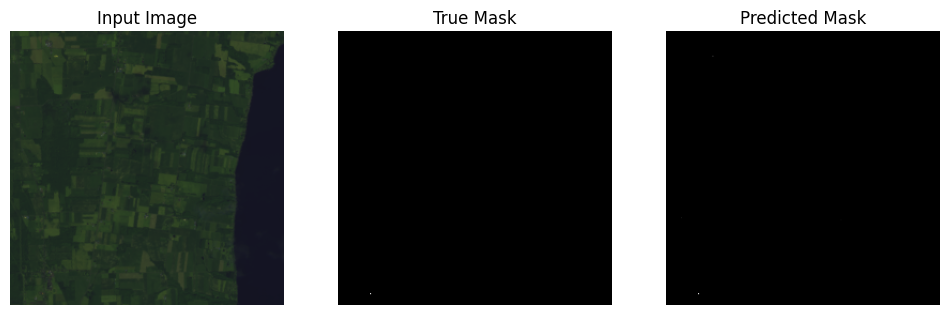

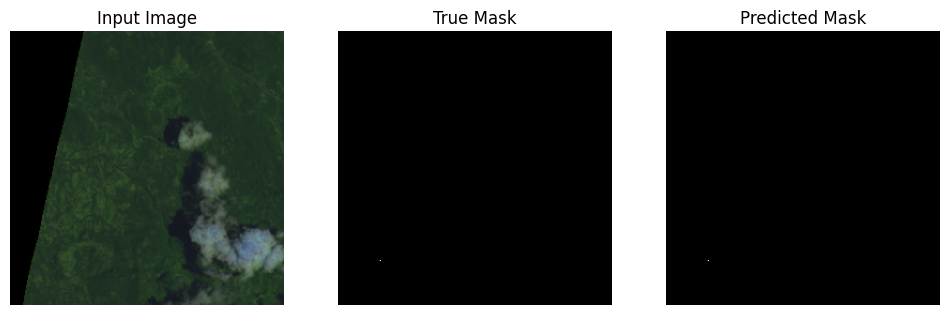

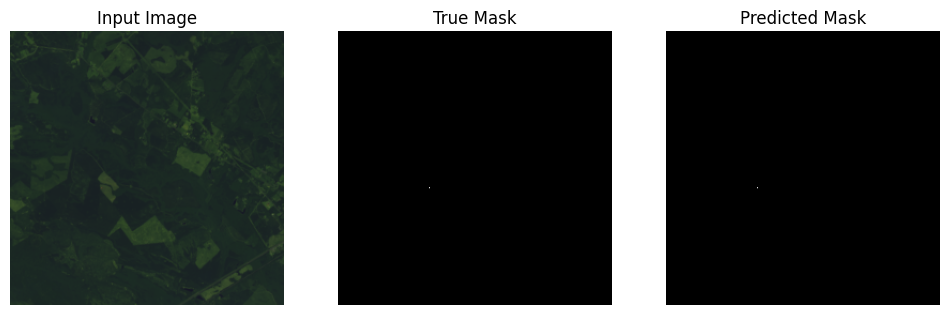

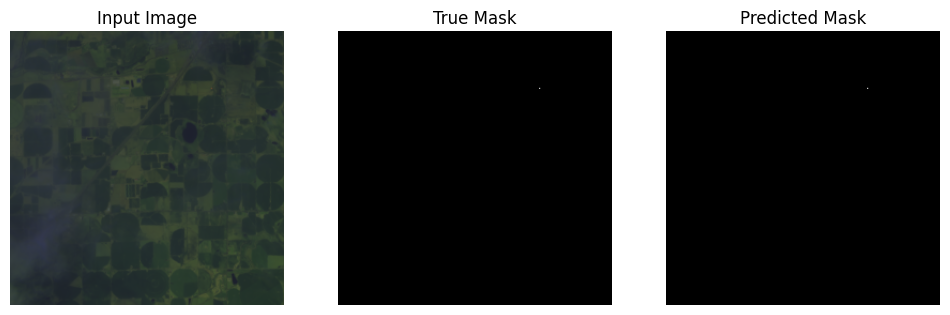

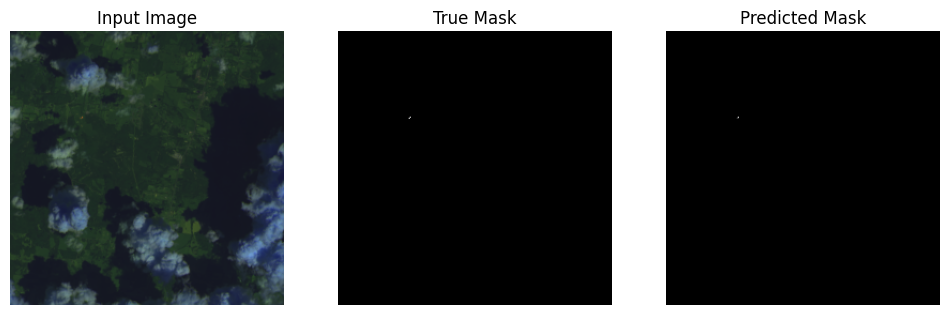

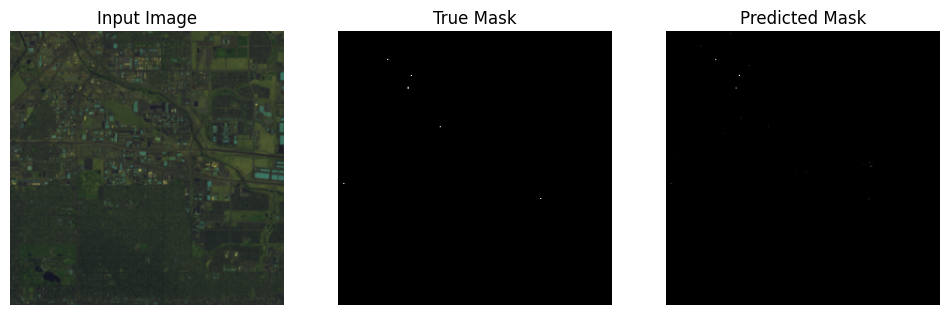

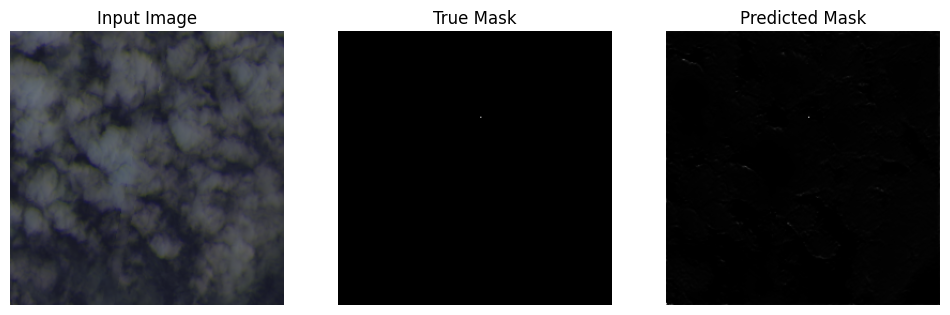

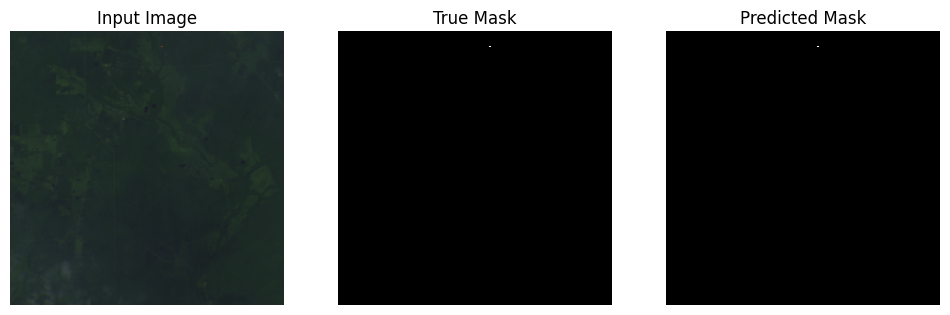

1/1 [==============================] - 0s 28ms/step


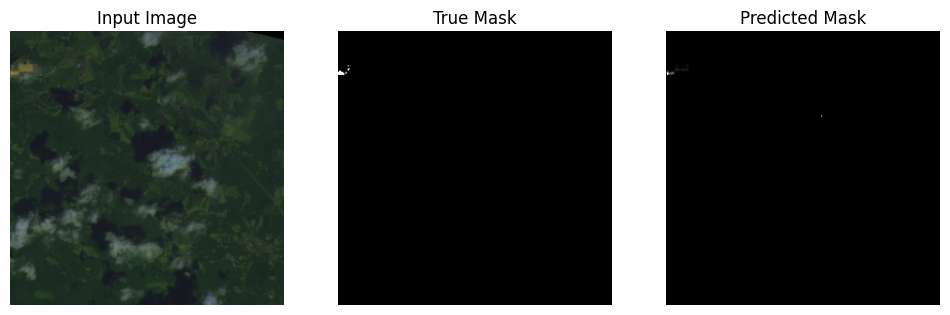

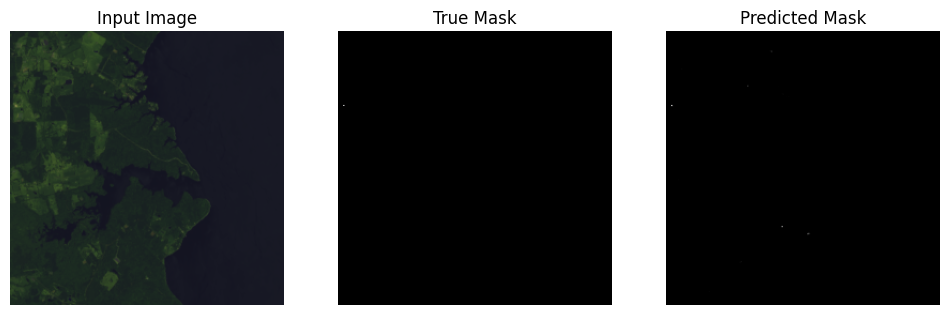

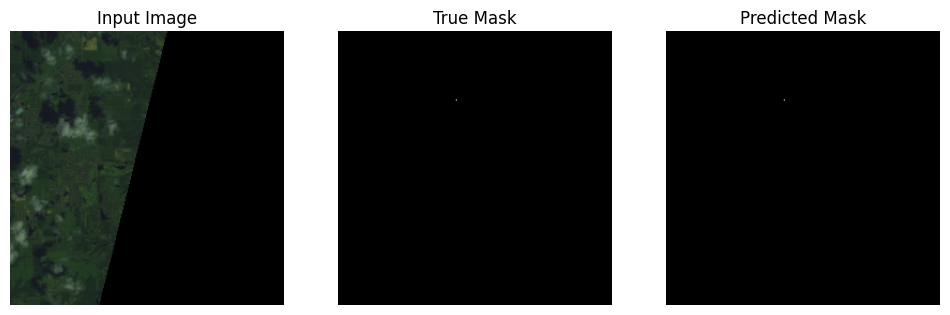

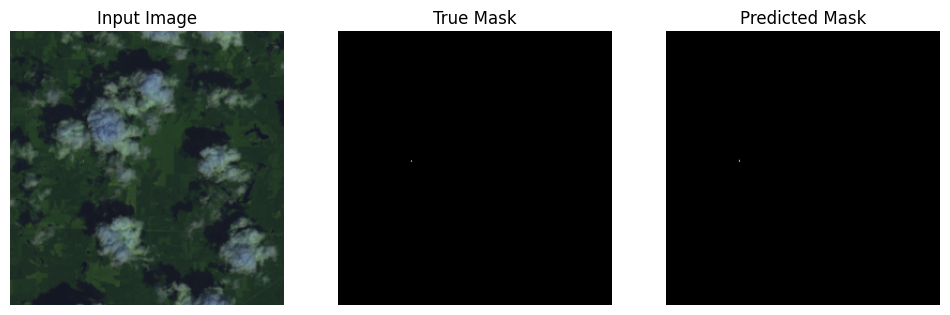

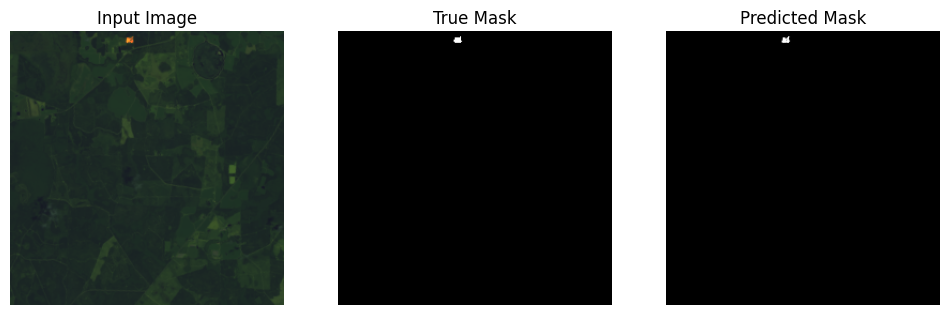

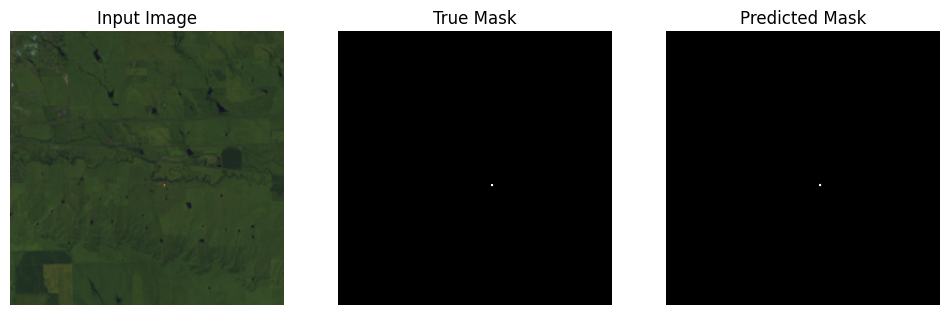

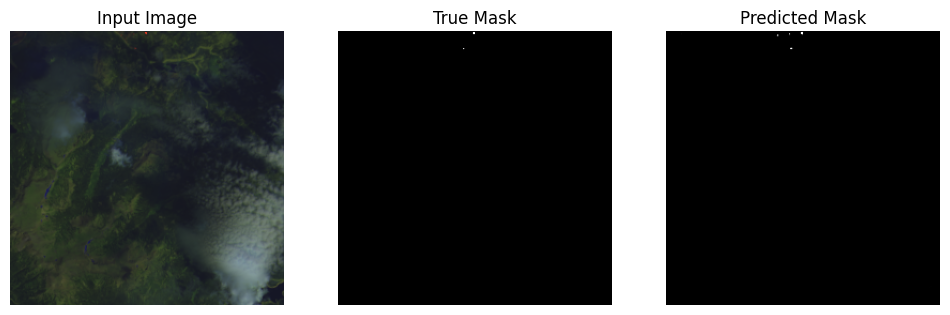

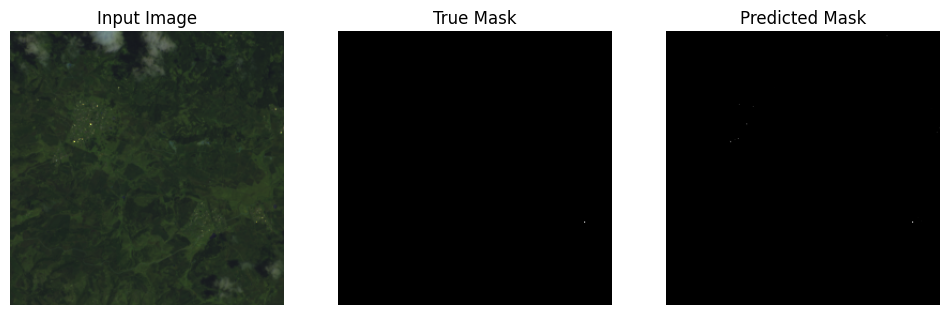

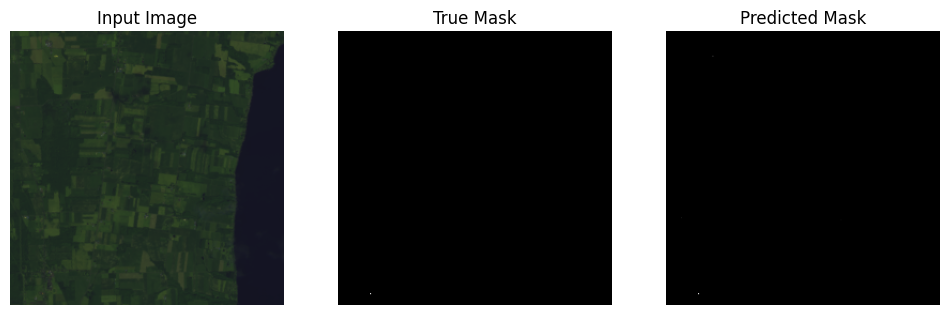

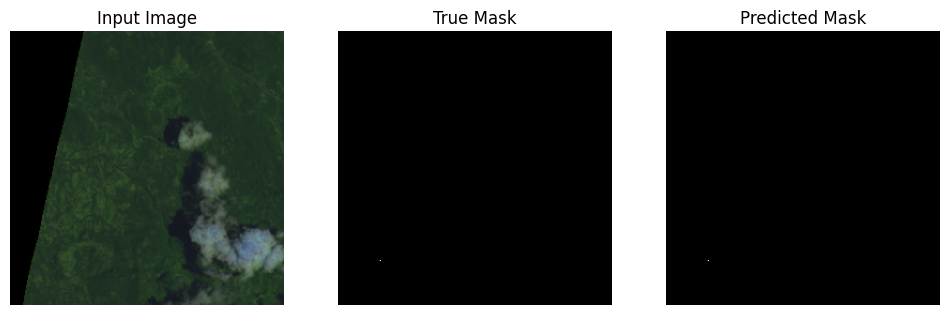

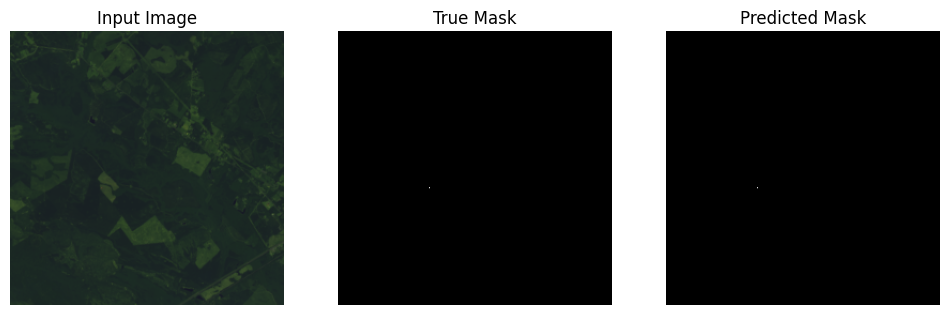

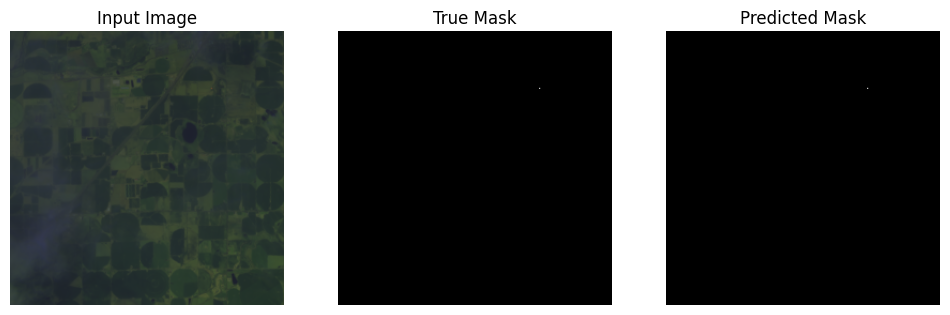

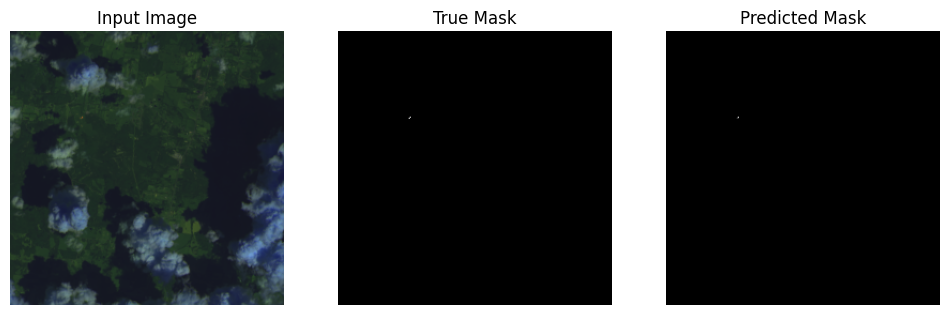

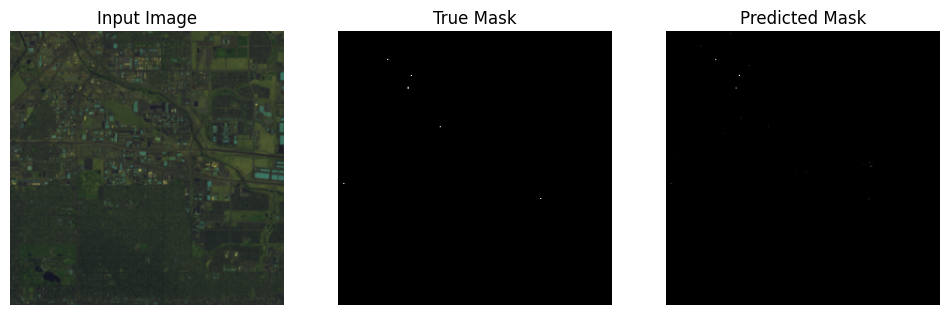

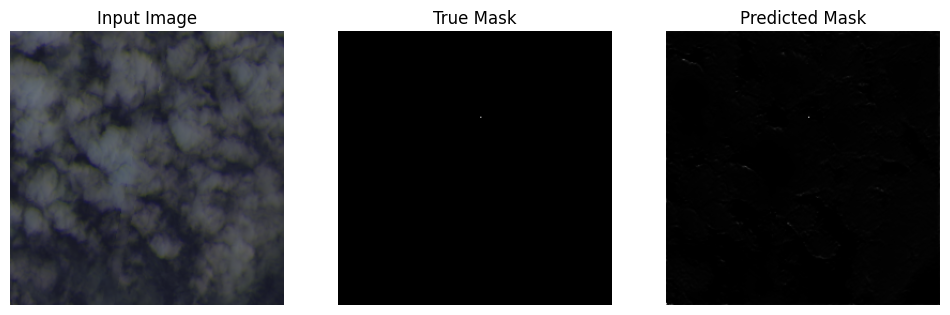

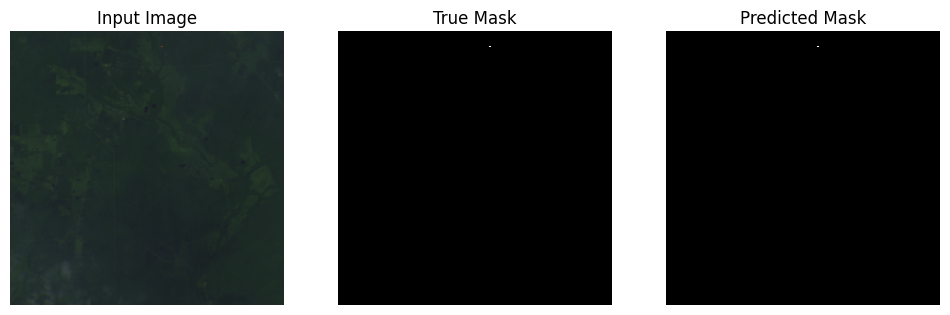

1/1 [==============================] - 0s 28ms/step


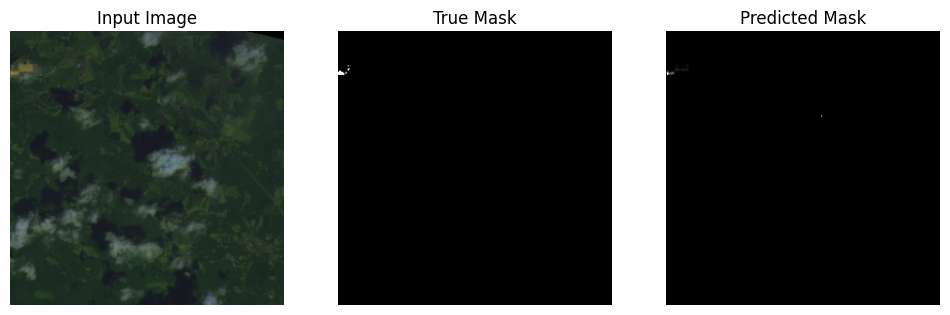

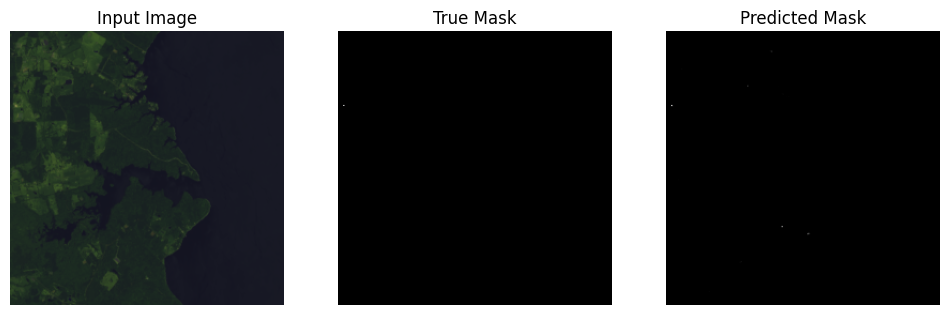

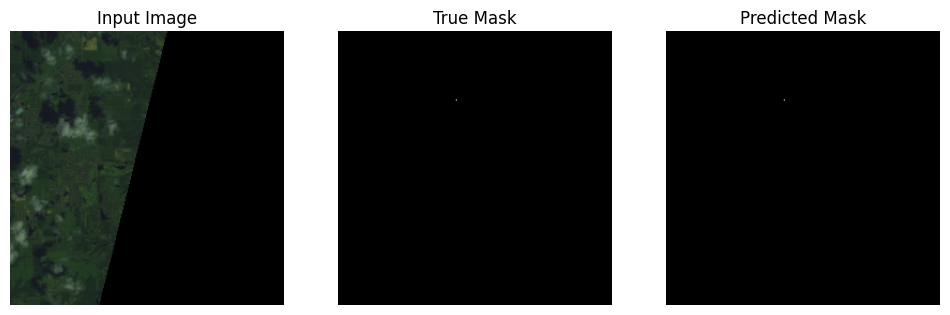

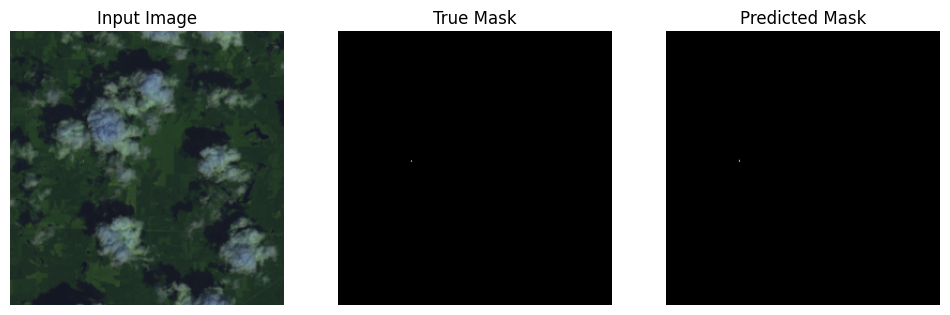

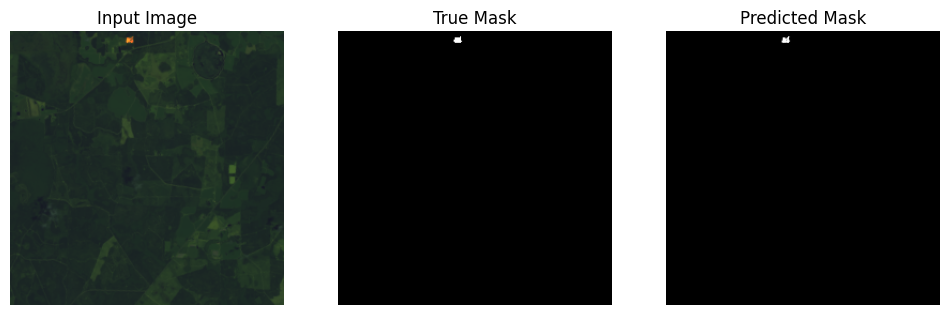

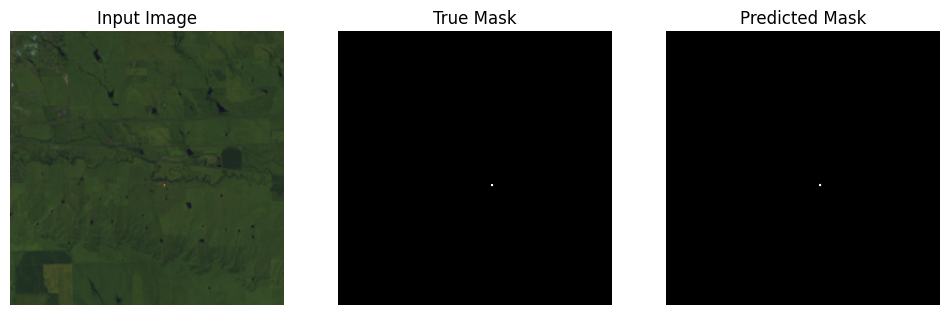

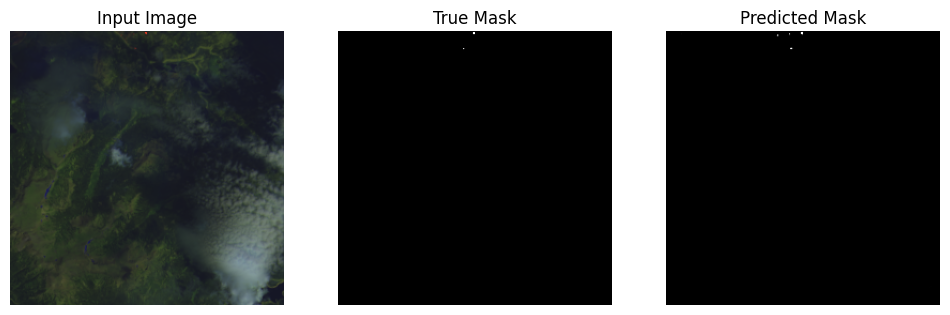

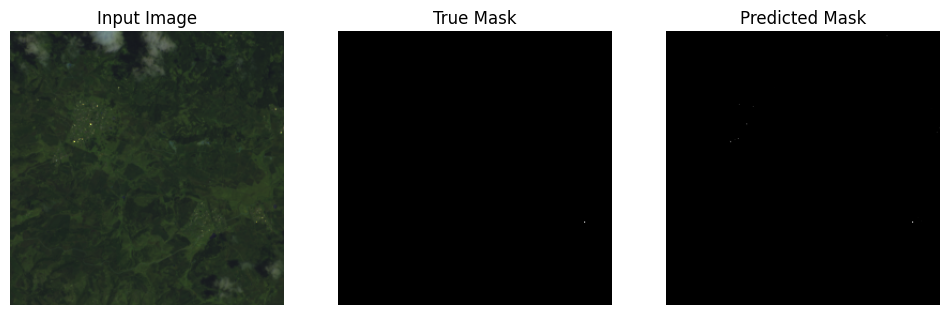

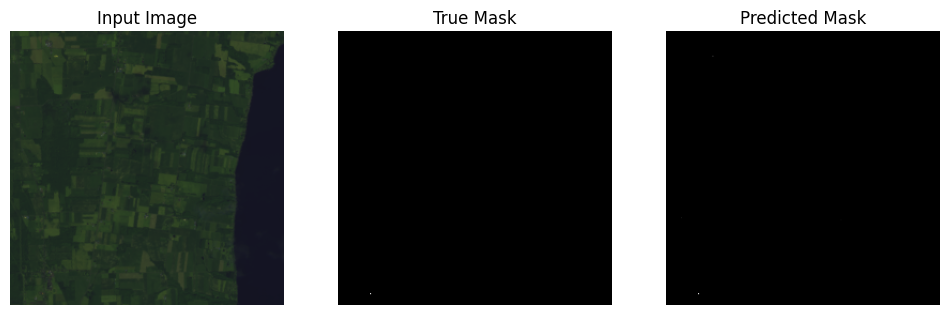

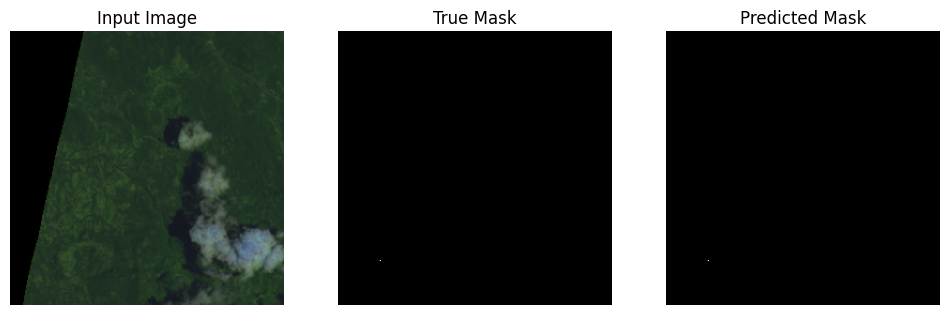

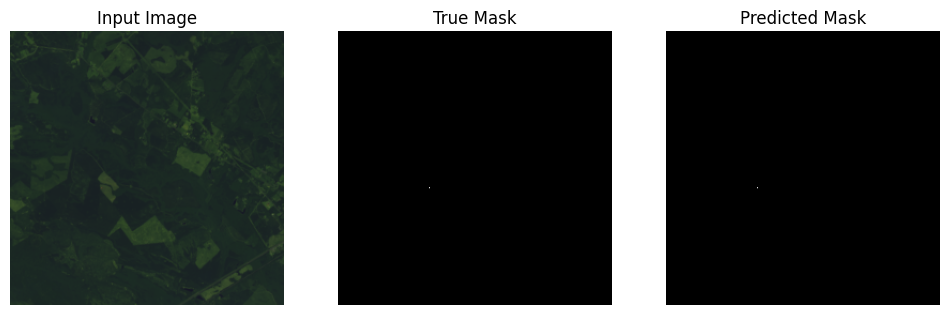

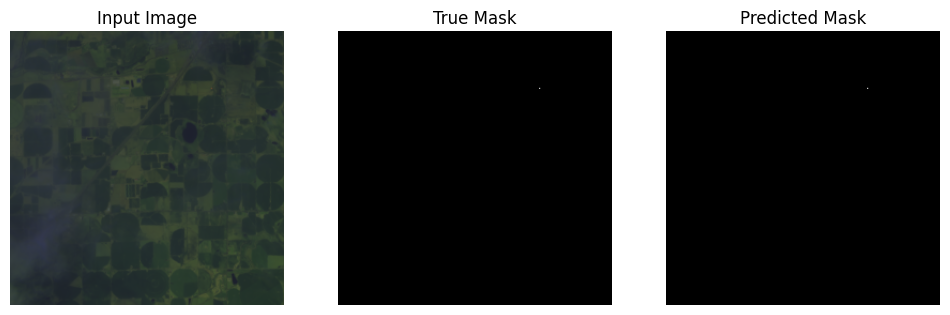

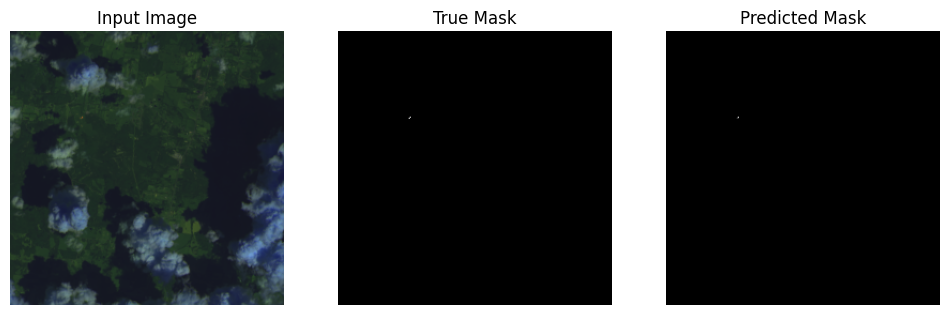

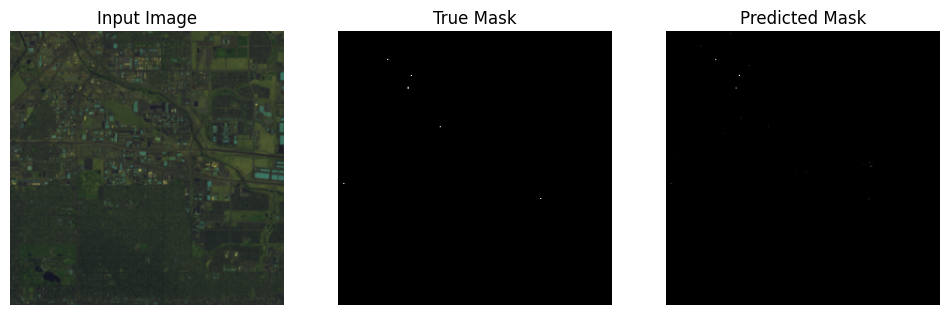

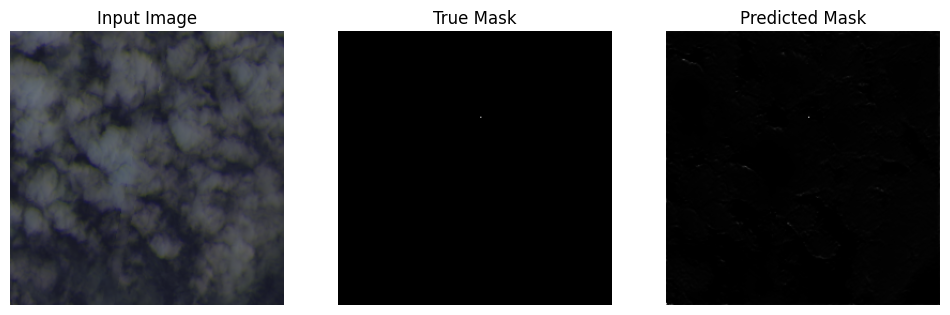

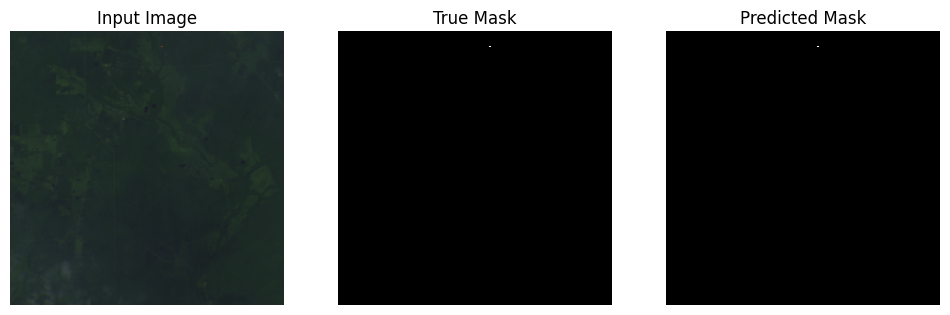

In [ ]:
def plot_predictions(model, generator, num_samples=5):
    """
    Plots a side-by-side comparison of the input images, the true masks,
    and the predicted masks for a given number of samples from the dataset.

    Parameters:
    - model: The trained model for making predictions.
    - generator: The data generator providing batches of inputs and true masks.
    - num_samples: Number of samples to visualize.
    """
    for _ in range(num_samples):
        # Get a batch from the generator
        x_batch, y_true_batch = next(iter(generator))
        y_pred_batch = model.predict(x_batch)

        for x, y_true, y_pred in zip(x_batch, y_true_batch, y_pred_batch):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(x)
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(y_true.squeeze(), cmap='gray')
            plt.title("True Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(y_pred.squeeze(), cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

# Assuming you have a 'model' and 'val_gen' already set up from previous steps
plot_predictions(model, val_gen, num_samples=3)

In [ ]:
def evaluate_model(model, generator, num_batches):
    """
    Evaluates the model on the given dataset generator.

    Parameters:
    - model: The trained model.
    - generator: The data generator for the dataset to evaluate.
    - num_batches: Number of batches to evaluate on.
    """
    precisions, recalls, ious = [], [], []
    iou = MeanIoU(num_classes=2)

    for _ in range(num_batches):
        x_batch, y_true_batch = next(iter(generator))
        y_pred_batch = model.predict(x_batch)
        y_pred_batch = y_pred_batch > 0.5  # Convert probabilities to binary predictions

        # Calculate precision and recall
        precision = Precision()
        recall = Recall()

        precision.update_state(y_true_batch, y_pred_batch)
        recall.update_state(y_true_batch, y_pred_batch)

        precisions.append(precision.result().numpy())
        recalls.append(recall.result().numpy())

        # Calculate IoU
        y_true_batch_int = np.round(y_true_batch).astype(int)
        y_pred_batch_int = np.round(y_pred_batch).astype(int)

        iou.reset_state()  # Reset the state for new calculation
        iou.update_state(y_true_batch_int, y_pred_batch_int)
        ious.append(iou.result().numpy())

    # Print the average metrics
    print(f"Precision: {np.mean(precisions)}, Recall: {np.mean(recalls)}, IoU: {np.mean(ious)}")

# Evaluate the model
evaluate_model(model, val_gen, num_batches=10)  # Adjust `num_batches` as necessary

1/1 [==============================] - 0s 28ms/step
Precision: 0.9074074625968933, Recall: 0.5568181276321411, IoU: 0.7634199261665344


Plot training & validation loss values

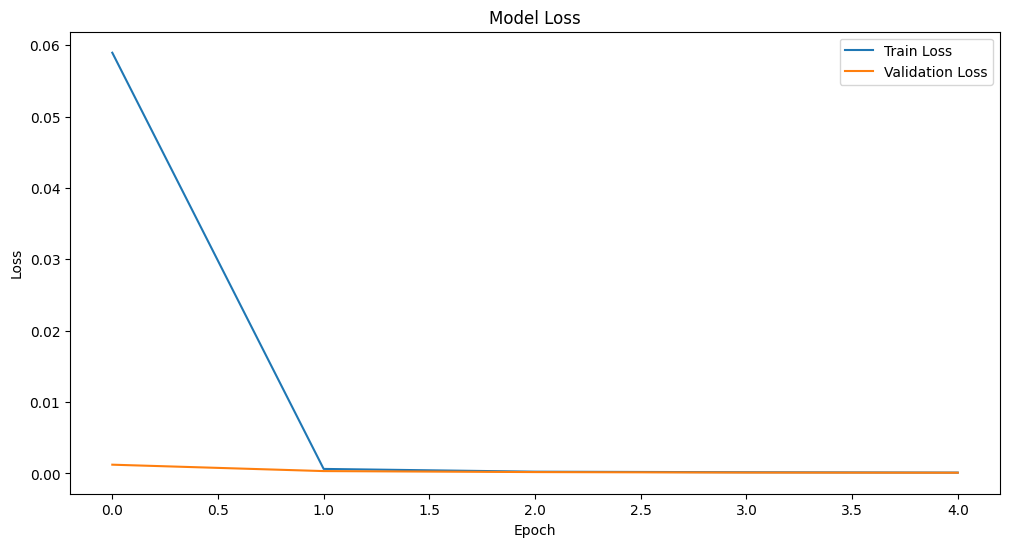

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

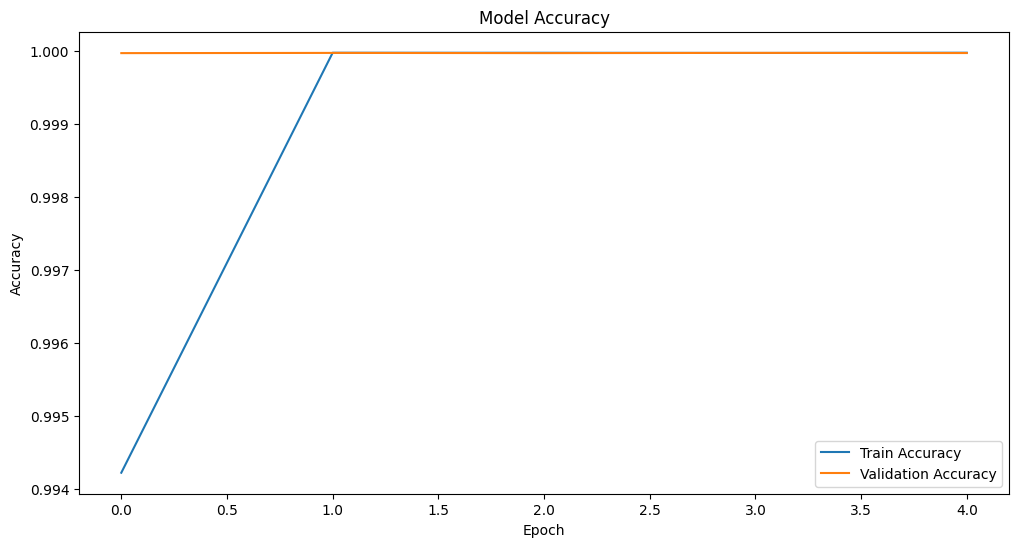

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def mask_coverage_percentage(mask_path):
    """
    Calculate the percentage of the area covered by the mask.

    Parameters:
    - mask_path: The file path to the mask image.

    Returns:
    - coverage: The percentage of the mask area relative to the image size.
    """
    mask = read_mask(mask_path)
    total_pixels = mask.size
    covered_pixels = np.count_nonzero(mask)
    coverage = (covered_pixels / total_pixels) * 100
    return coverage

# Iterate through the DataFrame and print names of images with masks covering more than 5% of the area
for index, row in df.iterrows():
    coverage = mask_coverage_percentage(row['mask'])
    if coverage > 1:
        print(f"Image: {row['image']} has a mask covering {coverage:.2f}% of the area.")


def filter_images_by_coverage(df, coverage_threshold=1):
    """
    Filter images by mask coverage.

    Parameters:
    - df: DataFrame containing the paths to images and masks.
    - coverage_threshold: The minimum coverage percentage to include an image.

    Returns:
    - filtered_df: A DataFrame with images having mask coverage above the threshold.
    """
    filtered_indices = []
    for index, row in df.iterrows():
        coverage = mask_coverage_percentage(row['mask'])
        if coverage > coverage_threshold:
            filtered_indices.append(index)

    return df.iloc[filtered_indices]

# Filter the DataFrame
filtered_df = filter_images_by_coverage(df, coverage_threshold=1)
print(f"Filtered {len(filtered_df)} images with mask coverage > 1%.")


Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/z040038/LC08_L1TP_040038_20200813_20200814_01_RT_p00816.tif has a mask covering 1.32% of the area.
Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/z040038/LC08_L1TP_040038_20200813_20200814_01_RT_p00816.tif has a mask covering 1.99% of the area.
Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/z040038/LC08_L1TP_040038_20200813_20200814_01_RT_p00816.tif has a mask covering 1.12% of the area.
Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/z024038/LC08_L1TP_024038_20200813_20200813_01_RT_p00727.tif has a mask covering 1.21% of the area.
Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/z024038/LC08_L1TP_024038_20200813_20200813_01_RT_p00727.tif has a mask covering 1.10% of the area.
Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/z035033/LC08_L1TP_035033_20200810_20200810_01_RT_p00232.tif has a mask covering 1.30% of the area.
Image: /content/drive/MyDrive/Colab Notebooks/CV_data/na2/

In [ ]:
def calculate_iou(true_mask, pred_mask):
    """
    Calculate the Intersection over Union (IoU) for a single prediction.

    Parameters:
    - true_mask: The true binary mask.
    - pred_mask: The predicted binary mask.

    Returns:
    - iou: The IoU score.
    """
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask) > 0.1  # Apply threshold to convert to binary mask
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

1/1 [==============================] - 1s 901ms/step


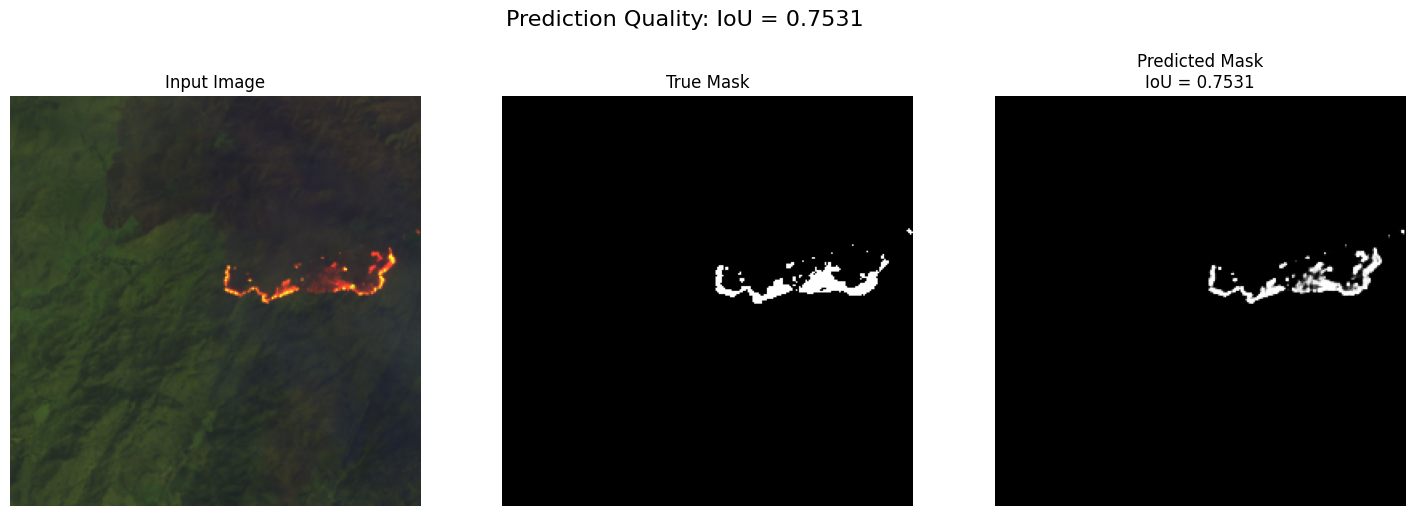

1/1 [==============================] - 0s 22ms/step


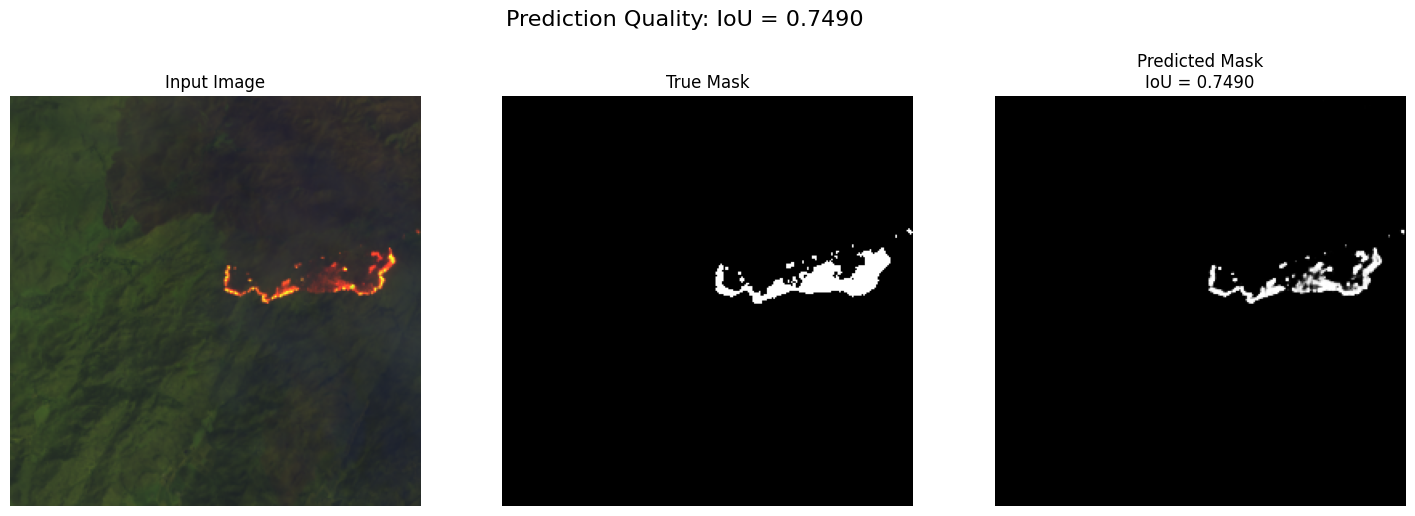

1/1 [==============================] - 0s 22ms/step


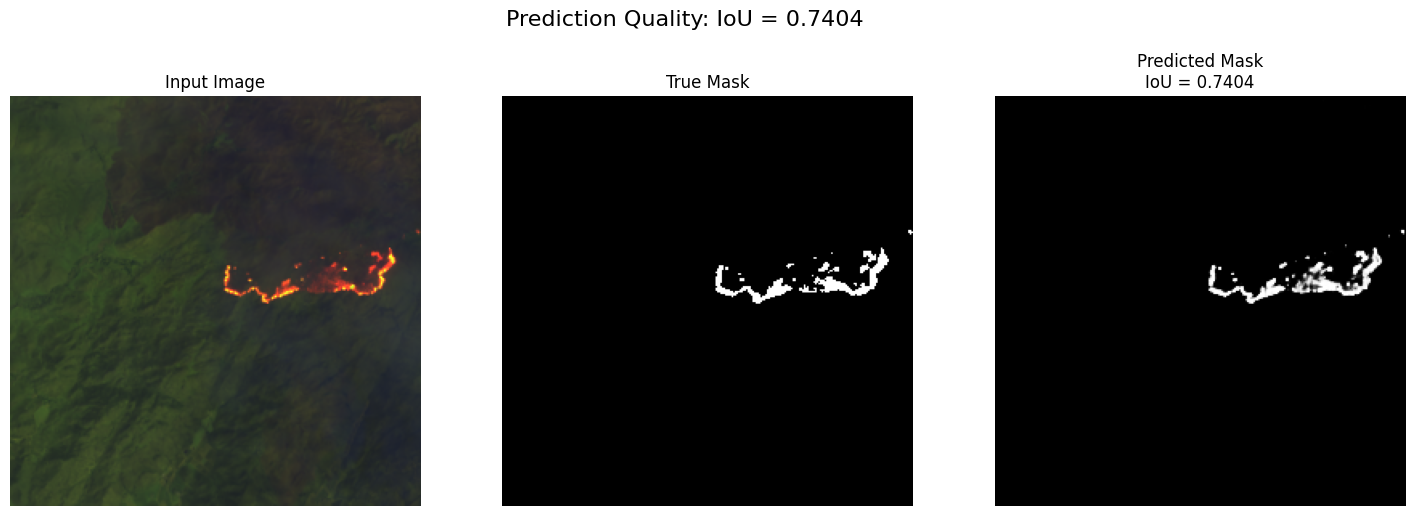

1/1 [==============================] - 0s 22ms/step


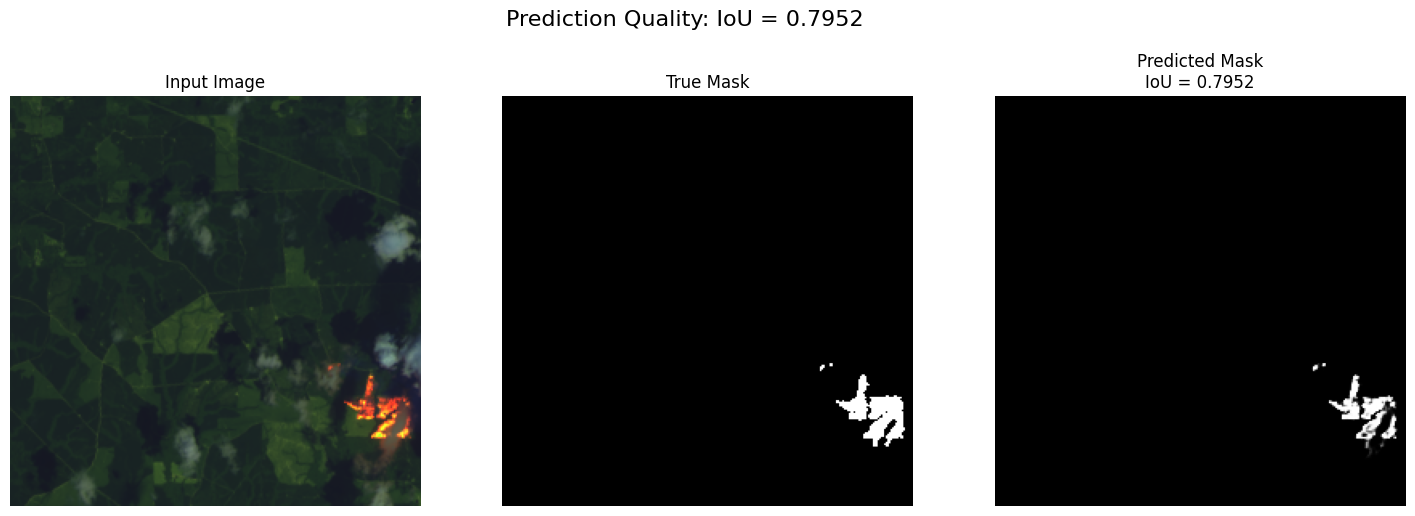

1/1 [==============================] - 0s 22ms/step


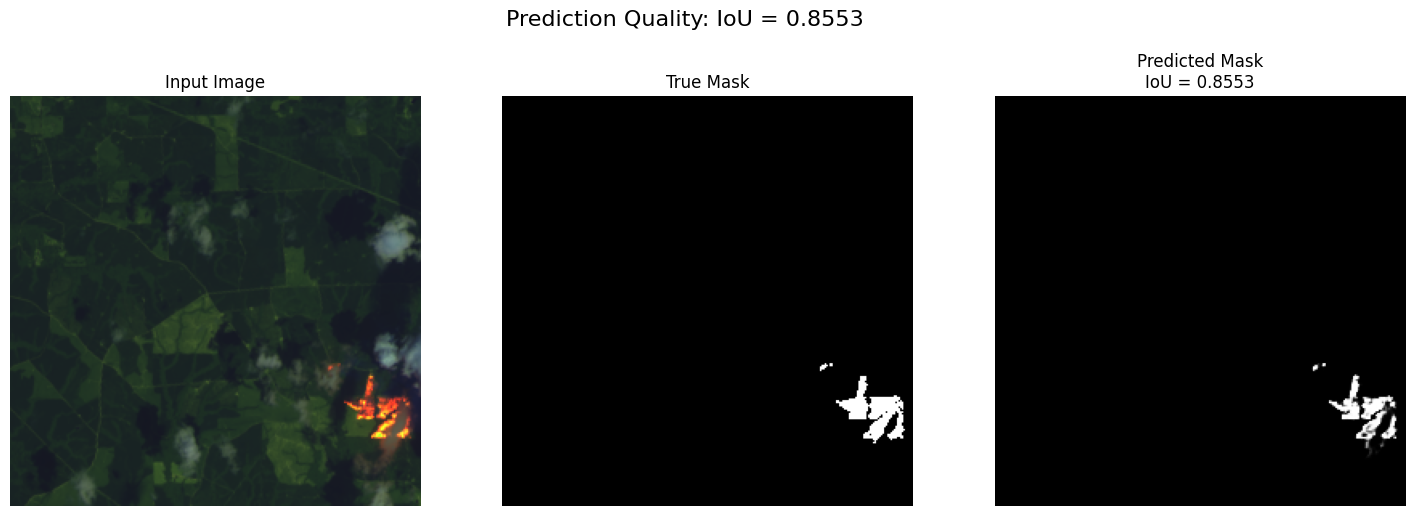

1/1 [==============================] - 0s 24ms/step


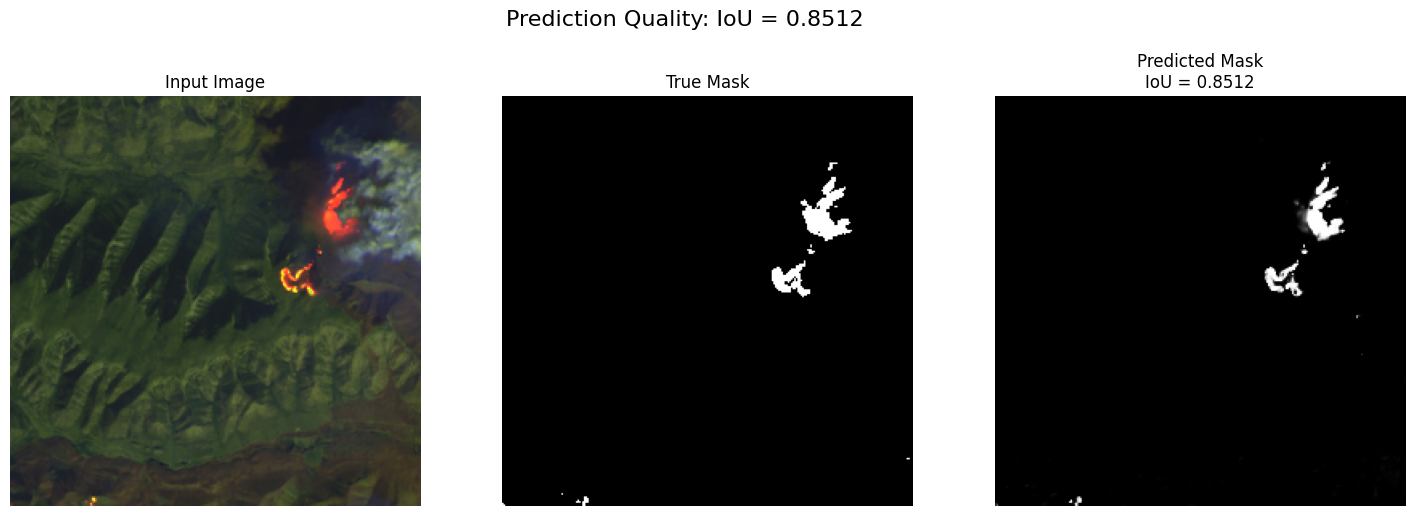

1/1 [==============================] - 0s 24ms/step


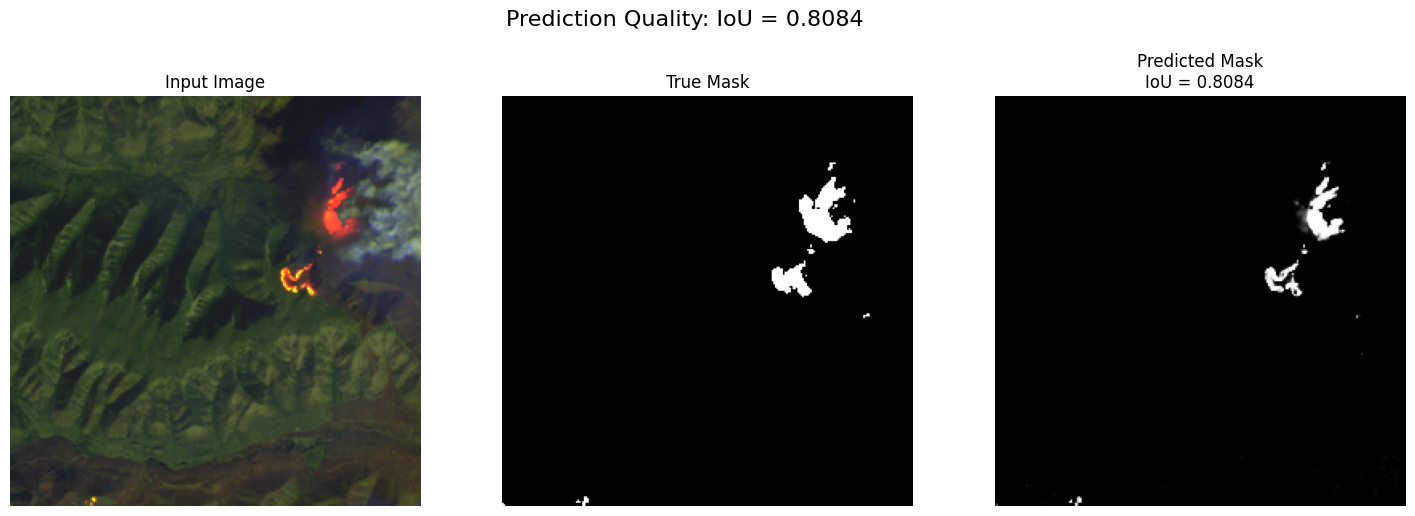

1/1 [==============================] - 0s 24ms/step


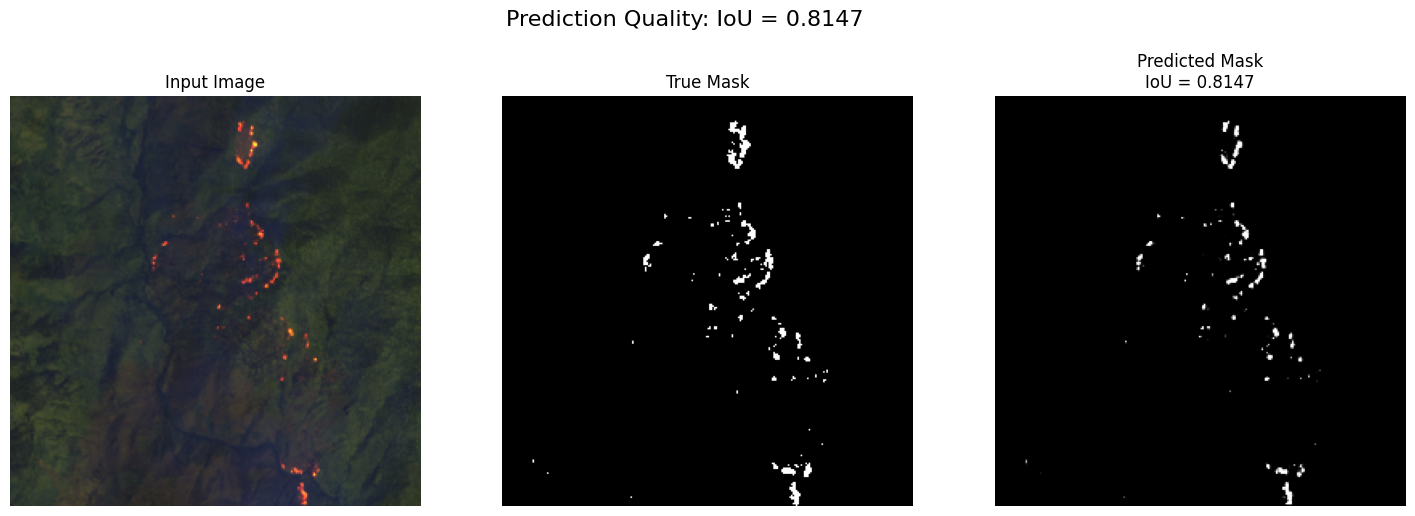

In [ ]:
def plot_filtered_images_with_quality(filtered_df, model, num_samples=3):
    """
    Plot the input image, true mask, and predicted mask for filtered images,
    and print the IoU score for each prediction.

    Parameters:
    - filtered_df: DataFrame containing the filtered images and masks.
    - model: The trained model for making predictions.
    - num_samples: Number of samples to visualize.
    """
    sampled_df = filtered_df.sample(n=num_samples) if len(filtered_df) > num_samples else filtered_df
    for index, row in sampled_df.iterrows():
        img = read_img(row['image'])
        true_mask = read_mask(row['mask'])
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        iou_score = calculate_iou(true_mask, pred_mask)

        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        pred_mask_display = pred_mask.squeeze()
        plt.imshow(pred_mask_display, cmap='gray')
        plt.title(f'Predicted Mask\nIoU = {iou_score:.4f}')
        plt.axis('off')

        plt.suptitle(f"Prediction Quality: IoU = {iou_score:.4f}", fontsize=16)
        plt.show()

# Assuming 'model' is your trained model
plot_filtered_images_with_quality(filtered_df, model, num_samples=8)
